# Network Intrusion Detection 99% Accuracy

### Key Insights

- Anomaly Detection: With a high precision score, the model is effectively identifying rare events (e.g., fraudulent transactions, system failures, or security breaches) with minimal false positives. This allows your business to focus resources on investigating actual issues rather than wasting time on false alarms.

- Risk Mitigation: The high AUC-PR score suggests that the model is effective at detecting anomalies across various thresholds. This can help you in decision-making related to risk mitigation, prioritizing high-risk situations or customers for immediate action.

- Cost Efficiency: Since the model has a low false positive rate (precision), it reduces unnecessary actions. For example, in a fraud detection scenario, it means fewer legitimate customers are incorrectly flagged, improving customer satisfaction and reducing operational costs.

- Enhanced Security: If you're working on a security-related project, such as detecting potential cyber attacks or intrusions in a network, the model’s effectiveness can help in proactively securing systems, preventing breaches before they escalate.

- Customer Insights: The model could also help segment customers, highlighting high-risk users or areas where additional attention may be required to improve service or prevent churn, thus driving better customer retention strategies.

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
# Specify the path to the zip file
zip_file_path = 'Network Intrusion.zip'  # Replace with your zip file path

# Specify the directory where the zip will be extracted
extract_dir = 'network_intrusion_data'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

# Load the CSV files into dataframes
train_file_path = os.path.join(extract_dir, 'Train_data.csv')
test_file_path = os.path.join(extract_dir, 'Test_data.csv')

Extracted files: ['Test_data.csv', 'Train_data.csv']



Training Data Sample:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10     

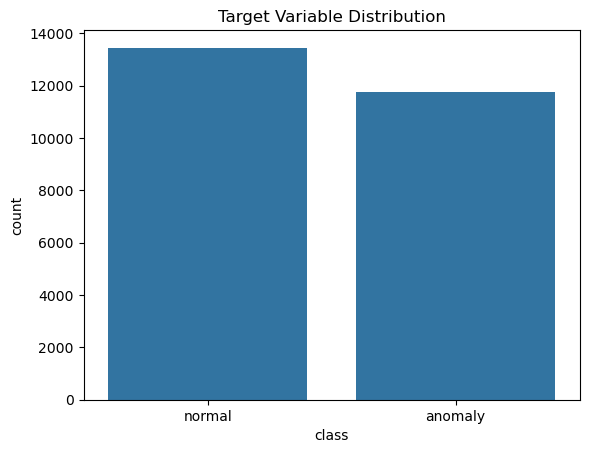

In [3]:
# Check if files exist
if os.path.exists(train_file_path) and os.path.exists(test_file_path):
    # Load the datasets
    train_df = pd.read_csv(train_file_path)
    test_df = pd.read_csv(test_file_path)

    # Display the first few rows of each dataframe
    print("\nTraining Data Sample:")
    print(train_df.head())
    
    print("\nTest Data Sample:")
    print(test_df.head())
else:
    print("Train_data.csv or Test_data.csv not found in the extracted files.")

# Display dataset information
print("\nTraining Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())

# Check for duplicate rows
print("\nDuplicate Rows in Training Data:", train_df.duplicated().sum())

# Visualize the target variable distribution
sns.countplot(data=train_df, x='class')
plt.title('Target Variable Distribution')
plt.show()

In [12]:
# Ensure 'class' column is excluded from non-numeric encoding
non_numeric_cols = train_df.select_dtypes(include=['object']).columns
non_numeric_cols = non_numeric_cols[non_numeric_cols != 'class']  # Exclude 'class' column
print("Non-numeric columns:", non_numeric_cols)

label_encoders = {}
for col in non_numeric_cols:
    label_encoders[col] = LabelEncoder()
    # Fit the LabelEncoder on both train and test data to ensure all possible values are captured
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0)  # Combine train and test columns
    label_encoders[col].fit(combined_data)
    train_df[col] = label_encoders[col].transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

# Ensure the specified categorical columns exist before applying one-hot encoding
categorical_cols = ['protocol_type', 'service', 'flag']
missing_cols = [col for col in categorical_cols if col not in train_df.columns]

if missing_cols:
    print(f"Missing columns in train_df: {missing_cols}")
else:
    print(f"Applying one-hot encoding for columns: {categorical_cols}")
    # One-hot encoding for categorical features (e.g., 'protocol_type', 'service', 'flag')
    train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
    test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align test dataset columns with train dataset columns to avoid misalignment
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# Continue with data splitting and model training...

Non-numeric columns: Index([], dtype='object')
Missing columns in train_df: ['protocol_type', 'service', 'flag']


In [13]:
# Split data into training and testing sets
X = train_df.drop('class', axis=1)  # Feature columns
y = train_df['class']  # Target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the training dataset (oversample anomalies)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train a Random Forest model on the balanced training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict on the scaled test data
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))


Classification Report on Test Data:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      2365
      normal       1.00      1.00      1.00      2674

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039




Precision Score: 0.9958970533383066
AUC-PR Score: 0.996926475448331


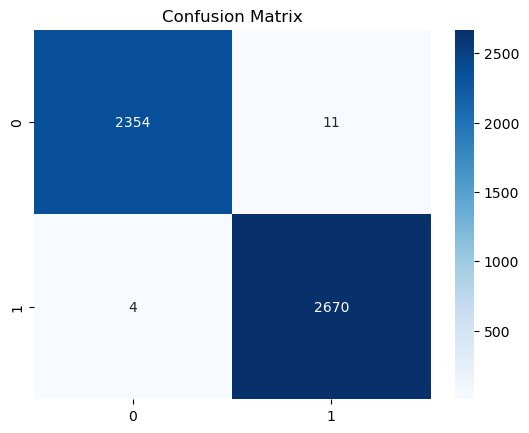

In [17]:
# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)

# Apply SMOTE to balance the training dataset (oversample anomalies)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_numeric)

# Train the model using the numeric labels after SMOTE
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict on the scaled test data
y_pred_numeric = rf_model.predict(X_test_scaled)

# Calculate precision and AUC-PR score using numeric labels
precision = precision_score(y_test_numeric, y_pred_numeric)
roc_auc = roc_auc_score(y_test_numeric, y_pred_numeric)

# Print precision and AUC-PR scores
print(f"\nPrecision Score: {precision}")
print(f"AUC-PR Score: {roc_auc}")

# Confusion matrix
sns.heatmap(confusion_matrix(y_test_numeric, y_pred_numeric), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

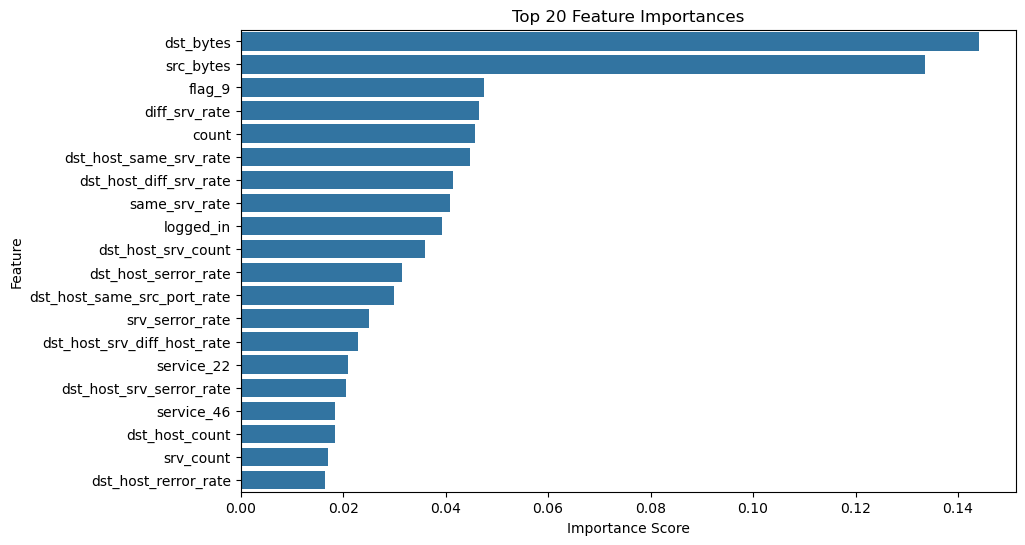

In [15]:
# Feature importance visualization
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Sort features by importance
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances[:20], y=sorted_features[:20], orient='h')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()